# Supercooled liquid

Import basic modules


In [ ]:
import numpy
import matplotlib.pyplot as plt

Simulation driver


In [ ]:
def main(input_system, output_file, model, seed=0, sample=0, T=0.0,
         nsteps=0.0, dt=0.001, period_thermo=0, block=None,
         dynamics='vv', quiet=False):

    import os
    import numpy
    import atooms.core
    from atooms.core.utils import setup_logging, mkdir
    from atooms.system import Thermostat
    from atooms.simulation import Simulation, Scheduler, write_config, write_thermo
    from atooms.simulation.observers import store
    from atooms.models import f90
    from atooms.dynamics import LangevinOverdamped, VelocityVerlet, NosePoincare
    from atooms.trajectory import Trajectory, TrajectoryXYZ

    # Initialize random numbers
    numpy.random.seed(seed)
    random = numpy.random.default_rng(seed)

    # Handle input
    if not quiet:
        atooms.core.progress.active = True
        setup_logging(level=20, update=True)
    else:
        atooms.core.progress.active = False
        setup_logging(level=40, update=True)

    # Always log to file
    mkdir(os.path.dirname(output_file))
    setup_logging(level=20, filename=output_file + '.log')

    # Initial state
    system = input_system

    # Setup interaction
    system.species_layout = 'F'
    system.interaction = f90.Interaction(model)
    # system.interaction.neighbor_list = f90.VerletList(skin=0.3)

    # Simulation backend
    assert dynamics in ['bd', 'vv', 'np'], 'wrong dynamics'
    if dynamics == 'bd':
        bck = LangevinOverdamped(system, timestep=dt, friction=1.0, temperature=T, fixed_cm=True, random=random)
    elif dynamics == 'vv':
        system.set_temperature(T)
        bck = VelocityVerlet(system, timestep=dt)
    elif dynamics == 'np':
        system.set_temperature(T)
        system.thermostat = Thermostat(temperature=T, mass=5.0)
        bck = NosePoincare(system, timestep=dt)

    sim = Simulation(bck, output_path=output_file)
    sim.trajectory_class = TrajectoryXYZ
    if block:
        sim.add(write_config, Scheduler(block=block))
    if period_thermo > 0:
        data = {}
        sim.add(store, period_thermo, ['steps', 'potential energy per particle', 
                                       'kinetic energy per particle',
                                       'temperature'], data)
        sim.add(write_thermo, period_thermo)
    sim.run(int(nsteps))

    return system, data

We look for the interaction model of the Kob-Andersen mixture in the
`atooms.models` database.


In [ ]:
from atooms import models
import pprint

model = models.get('kob_andersen')
pprint.pprint(model)

{'cutoff': [{'parameters': {'rcut': [[2.5, 2.0], [2.0, 2.2]]},
             'type': 'cut_shift'}],
 'potential': [{'parameters': {'epsilon': [[1.0, 1.5], [1.5, 0.5]],
                               'sigma': [[1.0, 0.8], [0.8, 0.88]]},
                'type': 'lennard_jones'}],
 'reference': 'W. Kob and H. C. Andersen, Phys. Rev. Lett. 73, 1376 (1994)',
 'version': 1}


We define a new model, changing the cutoff to a smoother one. This can
be passed to the simulation driver


In [ ]:
model = {'cutoff': [{'parameters': {'rcut': [[2.5, 2.0], [2.0, 2.2]]},
                     'type': 'quadratic_cut_shift'}],
         'potential': [{'parameters': {'epsilon': [[1.0, 1.5], [1.5, 0.5]],
                                       'sigma': [[1.0, 0.8], [0.8, 0.88]]},
                        'type': 'lennard_jones'}],
}

This is a little helper function to create a starting configuration with
appropriate chemical composition `x`, passed as a dictionary with
species as keys and chemical concentrations as values.


In [ ]:
def setup(N, density, x=None):
    import random
    from atooms.system import Particle, Cell, System

    if x is None:
        x = {'A': 1.0}

    # Find minimum number of particles to match input N
    cell = Cell([1.0, 1.0, 1.0])
    for n in range(1, 10):
        if n**3 >= N:
            n = n + 1
            break

    # Put particles on a cubic lattice
    a = 1.0 / n
    particle = []
    for ix in range(n):
        for iy in range(n):
            for iz in range(n):
                particle.append(Particle(position=[a*ix + a/2, a*iy + a/2, a*iz + a/2]))
    particle = random.sample(particle, N)
    system = System(cell=cell, particle=particle)
    system.density = density

    # Assign species
    N_sum = {species: int(N * x[species]) for species in x}
    for i in range(N - sum(N_sum.values())):
        species = sorted(x.keys())[i]
        N_sum[species] += 1
    assert sum(N_sum.values()) == N, 'input composition does not sum up to 1.0'

    new_particle = []
    for species in x:
        current = set(particle) - set(new_particle)
        sp = random.sample(current, N_sum[species])
        for p in sp:
            p.species = species
        new_particle += sp
    system.particle = new_particle

    return system

We create a little system of $N=108$ particles at the canonical density
$\rho=1.2$


In [ ]:
from atooms.system.particle import composition

system = setup(108, 1.2, {'A': 0.8, 'B': 0.2})
print(system)

system composed by 108 particles
enclosed in a cubic box at number density rho=1.200000



We equilibrate the system at $T=2.0$ (normal liquid state)


In [ ]:
system, data = main(system, output_file='/tmp/out1.xyz', model=model, nsteps=20000, dt=0.001, period_thermo=100, dynamics='np', T=2.0, quiet=True)
system, data = main(system, output_file='/tmp/out1.xyz', model=model, nsteps=20000, dt=0.004, period_thermo=100, dynamics='np', T=2.0, quiet=True)

Check that the energy looks good


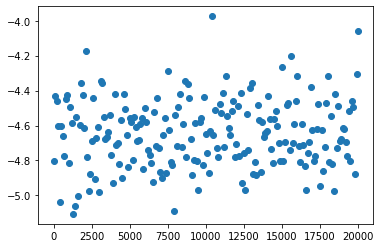

In [ ]:
plt.plot(data['steps'], data['potential energy per particle'], 'o')


Quench


In [ ]:
system, db = main(system, output_file='/tmp/out2.xyz', model=model, nsteps=200000, dt=0.002, period_thermo=1000, dynamics='np', T=0.5, quiet=True)
system, db = main(system, output_file='/tmp/out2.xyz', model=model, nsteps=200000, dt=0.004, period_thermo=1000, block=[1,2,4,10,20,40,100,200,400,1000,2000,4000], dynamics='np', T=0.5, quiet=True)

Check the potential energy


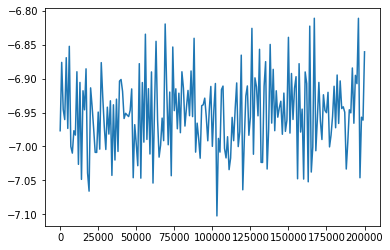

In [ ]:
data = numpy.loadtxt('/tmp/out2.xyz.thermo', unpack=True)
plt.plot(data[0], data[2])

![](/tmp/2.png)

Compute the $g(r)$ and MSD.


In [ ]:
from atooms.postprocessing import api
api.gr('/tmp/out2.xyz')
api.msd('/tmp/out2.xyz', func='logx')

Plot the g(r)


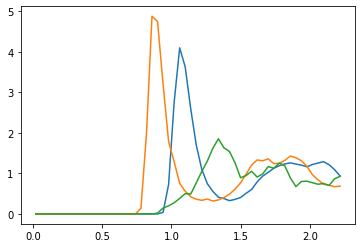

In [ ]:
gr11 = numpy.loadtxt('/tmp/out2.xyz.pp.gr.1-1', unpack=True)
gr12 = numpy.loadtxt('/tmp/out2.xyz.pp.gr.1-2', unpack=True)
gr22 = numpy.loadtxt('/tmp/out2.xyz.pp.gr.2-2', unpack=True)
plt.plot(gr11[0], gr11[1])
plt.plot(gr12[0], gr12[1])
plt.plot(gr22[0], gr22[1])

![](/tmp/gr.png)

Plot the MSD


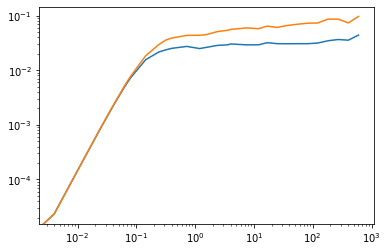

In [ ]:
msd1 = numpy.loadtxt('/tmp/out2.xyz.pp.msd.1', unpack=True)
msd2 = numpy.loadtxt('/tmp/out2.xyz.pp.msd.2', unpack=True)
plt.loglog(msd1[0], msd1[1])
plt.loglog(msd2[0], msd2[1])